# Importamos / exploramos

In [1]:
import pandas as pd

df = pd.read_json('../input/edu/od_matrix_per_zone.json', lines=True)

In [2]:
df.columns

Index(['dayofweek', 'destination_zone', 'origin_zone', 'period', 'trip_count'], dtype='object')

In [3]:
len(df.destination_zone.unique())

489

In [4]:
df.dayofweek.value_counts()

3    894646
1    880716
0    868793
2    853831
5    843751
4    822784
6    739586
Name: dayofweek, dtype: int64

In [5]:
df.period.value_counts()

afternoon_valley    1145316
afternoon_peak      1018560
morning_valley       900182
morning_peak_2       731730
night_valley         728344
morning_peak_1       701702
night                678273
Name: period, dtype: int64

In [6]:
week_days = range(0, 4)
drop_cols = ['dayofweek', 'period']
sample = df.query('dayofweek in @week_days and period == "morning_peak_1" and trip_count >= 10').drop(columns=drop_cols).sample(10000)

In [7]:
sample.shape

(10000, 3)

# Donde cortar
Las siguientes dos celdas se usaron para decir en que n de trip_count minimo usar para la muestra. (luego seguimos importando)

In [ ]:
trip_counts = []
for trip_count in sample.trip_count.values:
    for _ in range(trip_count):
        trip_counts.append(trip_count)

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-5, 15)

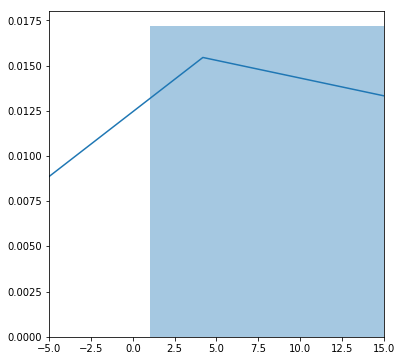

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(trip_counts, ax=ax)
ax.set_xlim(-5, 15)

In [8]:
# Alphas para las lineas
a, b = 0.0115, 0.115
x, y = sample.trip_count.min(), sample.trip_count.max()
normalized_tc = ((sample.trip_count - x) / (y - x) * (b - a) + a).values

In [9]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#import networkx as nx
#
#network = nx.Graph()
#for record in sample.to_records(index=False):
#    # Weights to parallels
#    for _ in range(record[2]):
#        network.add_edge(record[0], record[1])
#
#positions = nx.drawing.nx_pydot.graphviz_layout(network, prog='neato')        
#        
#plt.figure(figsize=(16, 16))
#nx.draw_networkx(network, pos=positions)

In [10]:
import json

with open('../input/edu/zonificacion_eod2012.geo.json') as json_file:
    data = json.load(json_file)

In [11]:
# Build key to point list
from shapely.geometry import Polygon

zone_to_coords = {}
for zone in data['features']:
    key = zone['properties']['ID']
    centroid = Polygon(zone['geometry']['coordinates'][0]).centroid
    zone_to_coords[key] = [centroid.x, centroid.y]

In [12]:
len(zone_to_coords)

866

# Convertimos a clases numba

In [13]:
from numba.typed import List
from numba.types import ListType
import ForceBundleFunctionalNumba

edges_data = List.empty_list(ForceBundleFunctionalNumba.Edge.class_type.instance_type)

for record in sample.to_records(index=False):
    # Weights to parallels
    #for _ in range(record[2]):
    source = ForceBundleFunctionalNumba.Point(zone_to_coords[record[0]][0], zone_to_coords[record[0]][1])
    target = ForceBundleFunctionalNumba.Point(zone_to_coords[record[1]][0], zone_to_coords[record[1]][1])
    edges_data.append(ForceBundleFunctionalNumba.Edge(source, target))

In [14]:
len(edges_data)

10000

# Aplicamos FDEB

In [15]:
#import importlib
#importlib.reload(ForceBundleFunctionalNumba)

# Set hyper-parameters:
#
# global bundling constant controlling edge stiffness
K = 0.1
# init.distance to move points
S_initial = 0.001
# init. subdivision number
P_initial = 1
# subdivision rate increase
P_rate = 2
# number of cycles to perform
C = 6
# init.number of iterations for cycle
I_initial = 65
# rate at which iteration number decreases i.e. 2 / 3
I_rate = 0.6666667  

output = ForceBundleFunctionalNumba.forcebundle(edges_data, S_initial, I_initial, I_rate, P_initial, P_rate, C, K)

# Exploramos resultados

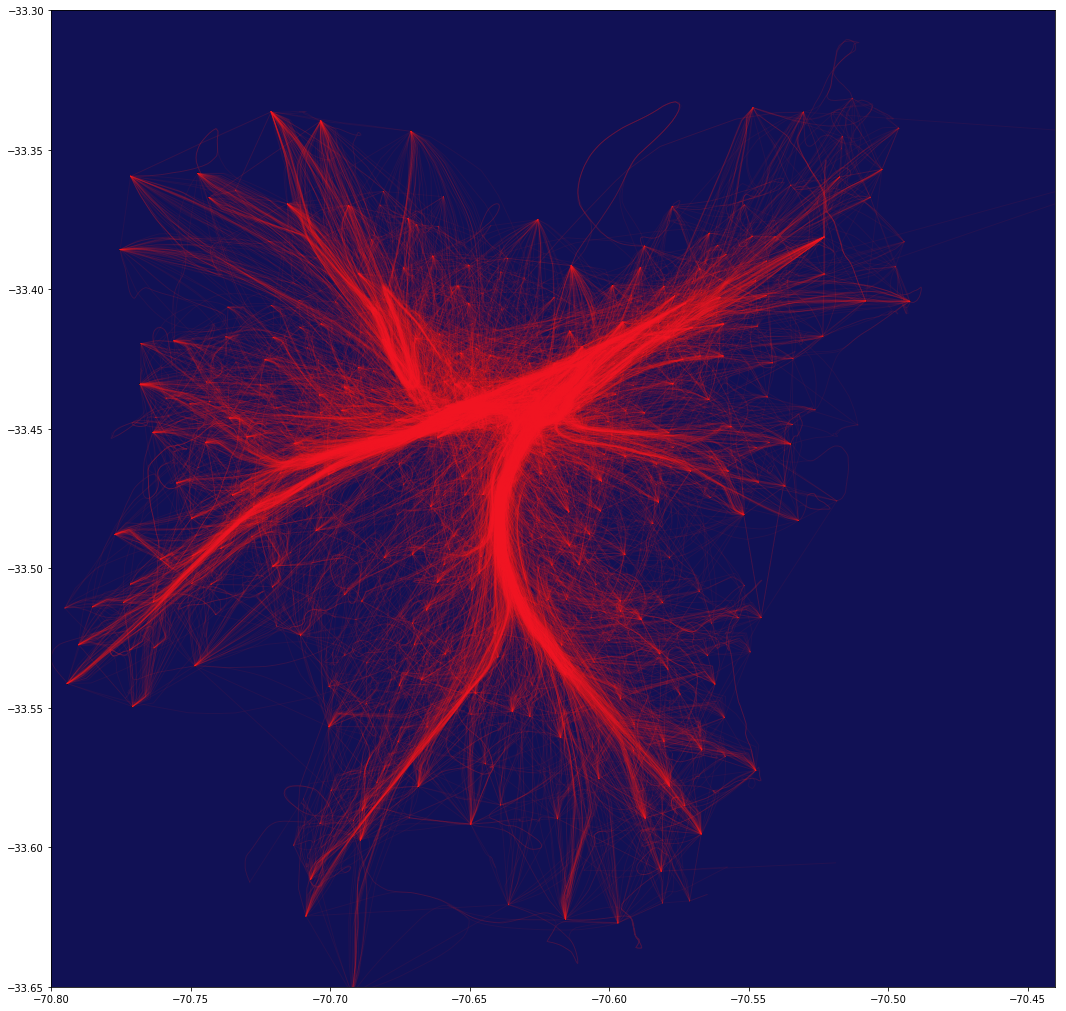

In [35]:
%matplotlib inline
import matplotlib.lines as lines
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 18))
ax.set_facecolor('#111155')
for edge_idx, edge in enumerate(output):
    xdata = []
    ydata = []
    
    for point in edge:
        #print(point.x)
        #print(point.y)
        xdata.append(point.x)
        ydata.append(point.y)
        
    line = lines.Line2D(xdata, ydata, linewidth=1, axes=ax, color='#ff2222', alpha=0.07)
    #line = lines.Line2D(xdata, ydata, linewidth=1, axes=ax, color='#ff2222', alpha=normalized_tc[edge_idx])
    
    ax.add_line(line)
    
#ax.scatter(x, y, s=10, c='#ffee00')
ax.set_xlim(-70.8, -70.44)
ax.set_ylim(-33.65, -33.3)
ax.set_aspect(1.0)
plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import LineString, Point

lines = []
for edge_idx, edge in enumerate(output):
    points = []
    
    for point in edge:
        points.append(Point(point.x, point.y))
        #print(point.x)
        #print(point.y)
        xdata.append(point.x)
        ydata.append(point.y)
        
    lines.append(LineString(points))

In [25]:
gdf = gpd.GeoSeries(lines)

In [36]:
gdf.to_pickle('lines.pk')

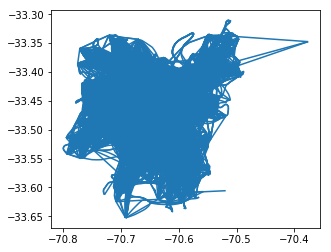

In [26]:
gdf.plot()

In [3]:
import geopandas as gpd
import pickle

with open('lines.pk', 'rb') as file:
    gdf = pickle.load(file)
    
with open('sample.pk', 'rb') as file:
    sample = pickle.load(file)
    
with open('normalized_tc.pk', 'rb') as file:
    normalized_tc = pickle.load(file)

In [22]:
# Solo lineas (sin curvas de DFEB)
from shapely.geometry import LineString, Point

def remove_curves(line):
    return LineString([line.coords[0], line.coords[-1]])

straightSeries = gdf.apply(remove_curves)

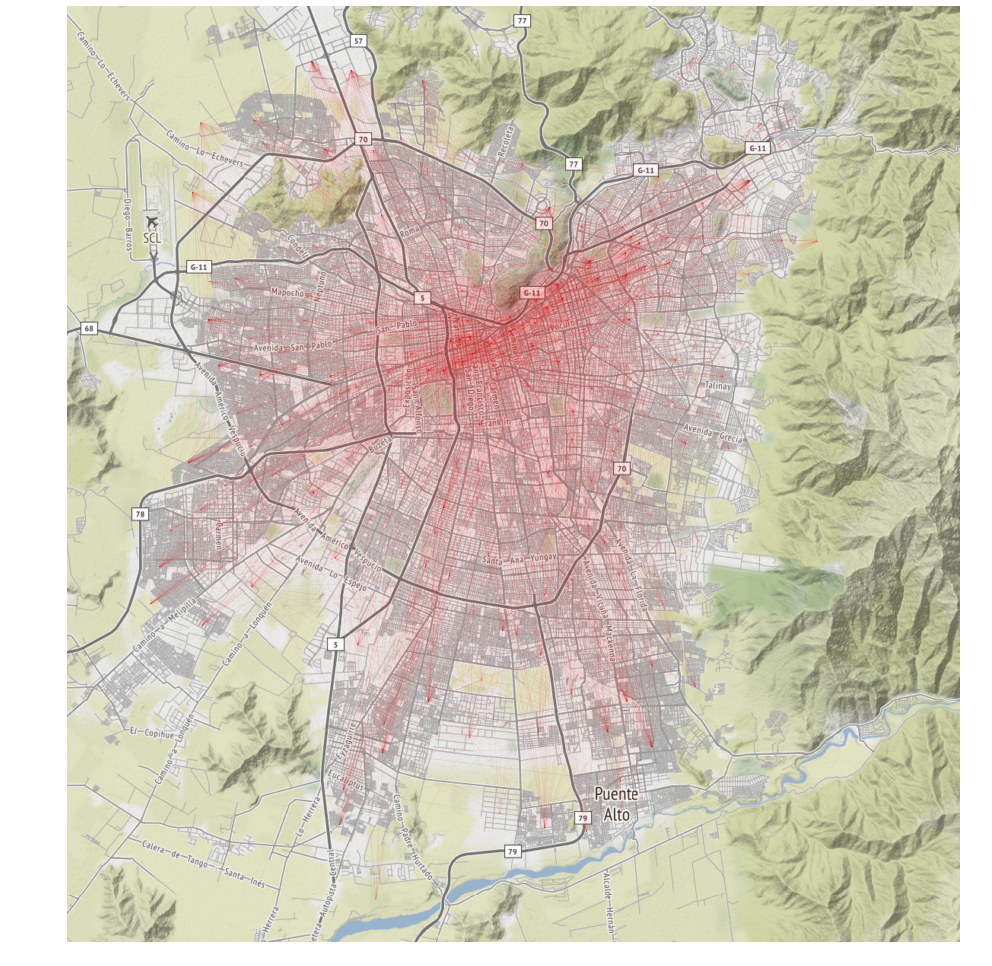

In [55]:
%matplotlib inline
import contextily as ctx
#import matplotlib.pyplot as plt


def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    

straightGdf = gpd.GeoDataFrame(geometry=straightSeries)
straightGdf.crs = {'init': 'epsg:4326'}
#straightGdf['ntc'] = normalized_tc
straightGdf['tc'] = sample.trip_count.values
ax = straightGdf.to_crs({'init': 'epsg:3857'}).plot(linewidth=.2, color='#ff2222', figsize=(16,20), alpha=0.115)
add_basemap(ax, zoom=12)
ax.set_xlim(-7885000, -7840000)
#ax.set_ylim(-33.65, -33.3)
plt.axis('off')
plt.savefig('morning_peak_1-lu_vi.png', bbox_inches='tight')
plt.show()
plt.close()

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import contextily as ctx
import matplotlib.pyplot as plt


def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    

gdf.crs = {'init': 'epsg:4326'}
ax = gdf.to_crs({'init': 'epsg:3857'}).plot(linewidth=.2, color='#ff2222', figsize=(32, 40), alpha=0.115*2)
add_basemap(ax, zoom=12)
ax.set_xlim(-7885000, -7840000)
#ax.set_ylim(-33.65, -33.3)
plt.axis('off')
plt.savefig('morning_peak_1-lu_vi-FDEB-weighted-norm.png', bbox_inches='tight')
#plt.show()
plt.close()